# MNIST

In this tutorial, we will show you how to train a small Convolutional Neural Network (CNN). We will train the model on the MNIST dataset, which consists of labeled handwritten digits. Each sample from the dataset is a 28x28 pixel grayscale (1 channel) image of a single handwritten digit and the label is an integer from 0 to 9.

For our model, we will be constructing the [LeNet model](http://yann.lecun.com/exdb/lenet/) with the sigmoid activations replaced with [ReLUs](http://www.cs.toronto.edu/~fritz/absps/reluICML.pdf). This tutorial will also give the option to use a simple Multi-layer Perceptron (MLP) model which does not include any convolutional operators. You may select the desired model via the *USE_LENET_MODEL* flag below.

Before we start, note that we will be using *ModelHelper* class in this tutorial. This class helps us deal with parameter initialization naturally and relieves us from having to maintain the param_init_net and net objects separately.

Before we start, let's import the necessities.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
%matplotlib inline
from matplotlib import pyplot
import numpy as np
import os
import shutil
import operator
import caffe2.python.predictor.predictor_exporter as pe

from caffe2.python import (
    brew,
    core,
    model_helper,
    net_drawer,
    optimizer,
    visualize,
    workspace,
)

# If you would like to see some really detailed initializations,
# you can change --caffe2_log_level=0 to --caffe2_log_level=-1
core.GlobalInit(['caffe2', '--caffe2_log_level=0'])
print("Necessities imported!")

# If True, use the LeNet CNN model
# If False, a multilayer perceptron model is used
USE_LENET_MODEL = True

Necessities imported!


## Data Download

We will handle the required data download for this tutorial and track statistics during training by setting up a top level local folder named `caffe2_notebooks` in the user's home directory. For the data download, we need to set up a `tutorial_data` folder, and for the training statistics we setup a `tutorial_files` folder. If you have run this tutorial before you should already have these folders. When the following cell is executed, it will make sure the training and test lmdb databases of MNIST dataset exist in the `tutorial_data` folder. 

In [2]:
# This section preps your image and test set in a lmdb database
def DownloadResource(url, path):
    '''Downloads resources from s3 by url and unzips them to the provided path'''
    import requests, zipfile, StringIO
    print("Downloading... {} to {}".format(url, path))
    r = requests.get(url, stream=True)
    z = zipfile.ZipFile(StringIO.StringIO(r.content))
    z.extractall(path)
    print("Completed download and extraction.")
    
# Setup the paths for the necessary directories 
current_folder = os.path.join(os.path.expanduser('~'), 'caffe2_notebooks')
data_folder = os.path.join(current_folder, 'tutorial_data', 'mnist')
root_folder = os.path.join(current_folder, 'tutorial_files', 'tutorial_mnist')
db_missing = False

# Check if the data folder already exists
if not os.path.exists(data_folder):
    os.makedirs(data_folder)   
    print("Your data folder was not found!! This was generated: {}".format(data_folder))

# Check if the training lmdb exists in the data folder
if os.path.exists(os.path.join(data_folder,"mnist-train-nchw-lmdb")):
    print("lmdb train db found!")
else:
    db_missing = True
    
# Check if the testing lmdb exists in the data folder   
if os.path.exists(os.path.join(data_folder,"mnist-test-nchw-lmdb")):
    print("lmdb test db found!")
else:
    db_missing = True

# Attempt the download of the db if either was missing
if db_missing:
    print("one or both of the MNIST lmbd dbs not found!!")
    db_url = "http://download.caffe2.ai/databases/mnist-lmdb.zip"
    try:
        DownloadResource(db_url, data_folder)
    except Exception as ex:
        print("Failed to download dataset. Please download it manually from {}".format(db_url))
        print("Unzip it and place the two database folders here: {}".format(data_folder))
        raise ex

# Clean up statistics from any old runs
if os.path.exists(root_folder):
    print("Looks like you ran this before, so we need to cleanup those old files...")
    shutil.rmtree(root_folder)
    
os.makedirs(root_folder)
workspace.ResetWorkspace(root_folder)

print("training data folder:" + data_folder)
print("workspace root folder:" + root_folder)

lmdb train db found!
lmdb test db found!
Looks like you ran this before, so we need to cleanup those old files...
training data folder:/home/rohit/caffe2_notebooks/tutorial_data/mnist
workspace root folder:/home/rohit/caffe2_notebooks/tutorial_files/tutorial_mnist


> If the database wasn't found in the last step, [download the MNIST lmdb database](https://download.caffe2.ai/databases/mnist-lmdb.zip) or review the [datasets and databases notebook](https://github.com/caffe2/caffe2/blob/master/caffe2/python/tutorials/MNIST_Dataset_and_Databases.ipynb) on how to create the database from the MNIST dataset.

## Model Construction

We will be using the `ModelHelper` class to represent our main model, and use the `brew` module as well as other normal Caffe2 operators to build our model. [`ModelHelper`](https://caffe2.ai/doxygen-python/html/classcaffe2_1_1python_1_1model__helper_1_1_model_helper.html) is a special class which stores a lot of information about parameter initializations, network structure, parameter names and later on mapping to gradients. We will see how it is used with `brew` in other places below.

To avoid confusion, be aware that *model.MyOperator* is a syntactic sugar for *model.net.MyOperator*, which adds the corresponding *MyOperator* operator to *model.net*.

**Introduction to brew**

`brew` is a collection of helper functions designed to simplify the addition of complex logic to our models (for more information click [here](https://caffe2.ai/docs/brew.html)). When we want to add parameter initialization as well as a computation step, for example, `brew` comes in handy. Now, lets explore this in more detail. 

The `brew` module has a set of wrapper functions that automatically separate the parameter intialization and the actual computation into two networks. Under the hood, a `ModelHelper` object has two underlying nets, `param_init_net` and `net`, that keep record of the initialization network and the main network respectively. Also `model.params` keeps track of parameter names.

**High Level Process**

For the sake of modularity, we will separate the construction of the model into different parts:

    (1) The data input part (AddInput function)
    (2) The main computation part (AddModel function)
    (3) The training part - adding gradient operators, optimization algorithm, etc. (AddTrainingOperators function)
    (4) The bookkeeping part, where we just print out statistics for inspection. (AddBookkeepingOperators function)
  
  
### Add Input

`AddInput` will load the data from a DB (specifically the lmdbs that were downloaded above). The loaded MNIST data is stored as pixel values in **NCHW** order, so after batching this will give us data with shape `[batch_size, num_channels, width, height]`. More specifically, since our MNIST data are 8-bit (*uint8*) grayscale images of size 28x28px, our data shape as input to the network is `[batch_size, 1, 28, 28]`, and our label type is *int* with shape `[batch_size]`.
    
Since we are going to do float computations, we will cast the data to the *float* data type.
For better numerical stability, instead of representing data in [0, 255] range, we will scale them down to [0, 1].
Note that we are doing in-place computation for this operator because we don't need the pre-scaled data.
Also, when computing the backward pass, we should specify that we will not need the gradient computation for the data preparation part. `StopGradient` does exactly that: in the forward pass it does nothing and in the backward pass all it does is tell the gradient generator "the gradient does not need to pass through here".
    

In [3]:
def AddInput(model, batch_size, db, db_type):
    ### load the data from db - Method 1 using brew
    #data_uint8, label = brew.db_input(
    #    model,
    #    blobs_out=["data_uint8", "label"],
    #    batch_size=batch_size,
    #    db=db,
    #    db_type=db_type,
    #)
    ### load the data from db - Method 2 using TensorProtosDB
    data_uint8, label = model.TensorProtosDBInput(
        [], ["data_uint8", "label"], batch_size=batch_size,
        db=db, db_type=db_type)
    # cast the data to float
    data = model.Cast(data_uint8, "data", to=core.DataType.FLOAT)
    # scale data from [0,255] down to [0,1]
    data = model.Scale(data, data, scale=float(1./256))
    # don't need the gradient for the backward pass
    data = model.StopGradient(data, data)
    return data, label

### MLP Model Definition

**Note**: This is the model used when the flag *USE_LENET_MODEL=False*

Now we are going to construct our own model. The input will be our data blob ($X$), and the output will be a vector of length 10 containing the network's prediction on each of the 10 possible digits in MNIST.

In this Multi-layer Perceptron (MLP) architecture, the ReLU activation function is going to be used and is defined as:

$$Relu(x) =\begin{cases}x & if x > 0\\ 0 & otherwise\end{cases}$$

Recall, each layer of an MLP is just matrix multiplication between some input data and a weight matrix ($W$), then an addition with a bias ($b$).  In machine learning this is accomplished with a fully-connected layer, which is aptly named [FC](https://caffe2.ai/docs/operators-catalogue.html#fc) in Caffe2. The result of this multiplication is then passed to a non-linear activation function (ReLU). The output of each activation function is passed to the next layer as the input data and this process is repeated through the layers as follows:

$ {layer_1 = Relu(XW_1^T + b_1) } $

$ {layer_2 = Relu(layer_1W_2^T + b_2) } $

$ {...} $

Once the data has propagated through the network in the forward pass, we will use the [Softmax](https://caffe2.ai/docs/operators-catalogue.html#softmax) operator to convert scores for each of the digits to probabilities. As a rule, the scores sum to one (i.e. $p_0 + ... + p_9 = 1.0$) and no single score is greater than or equal to one (i.e. $0 <= p_i <= 1.0$). A more detailed description of MLP can be found [here](http://deeplearning.net/tutorial/mlp.html).

In this function we are going to use Brew for the first time. Under the hood, when we call `brew.fc(model, layer, ...)` the following happens:

- The FC operator is added to `model.net` by calling `model.net.FC([layer, W, b], ...)`
- The initializations for $W$ and $b$ are added to the `model.param_init_net`

Hopefully, this makes the convenience of brew is clearer! 

In [4]:
# Function to construct a MLP neural network
# The input 'model' is a model helper and 'data' is the input data blob's name
def AddMLPModel(model, data):
    size = 28 * 28 * 1
    sizes = [size, size * 2, size * 2, 10]
    layer = data
    for i in range(len(sizes) - 1):
        layer = brew.fc(model, layer, 'dense_{}'.format(i), dim_in=sizes[i], dim_out=sizes[i + 1])
        layer = brew.relu(model, layer, 'relu_{}'.format(i))
    softmax = brew.softmax(model, layer, 'softmax')
    return softmax
    

### LeNet Model Definition

**Note**: This is the model used when the flag *USE_LENET_MODEL=True*

Below is another possible (and very powerful) architecture called LeNet. The primary difference from the MLP model is that LeNet is a Convolutional Neural Network (CNN), and therefore uses convolutional layers ([Conv](https://caffe2.ai/docs/operators-catalogue.html#conv)), max pooling layers ([MaxPool](https://caffe2.ai/docs/operators-catalogue.html#maxpool)), [ReLUs](https://caffe2.ai/docs/operators-catalogue.html#relu), *and* fully-connected ([FC](https://caffe2.ai/docs/operators-catalogue.html#fc)) layers. A full explanation of how a CNN works is beyond the scope of this tutorial but here are a few good resources for the curious reader:

- [Stanford cs231 CNNs for Visual Recognition](http://cs231n.github.io/convolutional-networks/) (**Recommended**)
- [Explanation of Kernels in Image Processing](https://en.wikipedia.org/wiki/Kernel_%28image_processing%29) 
- [Convolutional Arithmetic Tutorial](http://deeplearning.net/software/theano_versions/dev/tutorial/conv_arithmetic.html)

Notice, this function also uses Brew. However, this time we add more than just FC and Softmax layers.

In [5]:
def AddLeNetModel(model, data):
    '''
    This part is the standard LeNet model: from data to the softmax prediction.
    
    For each convolutional layer we specify dim_in - number of input channels
    and dim_out - number or output channels. Also each Conv and MaxPool layer changes the
    image size. For example, kernel of size 5 reduces each side of an image by 4.

    While when we have kernel and stride sizes equal 2 in a MaxPool layer, it divides
    each side in half.
    '''
    # Image size: 28 x 28 -> 24 x 24
    conv1 = brew.conv(model, data, 'conv1', dim_in=1, dim_out=20, kernel=5)
    # Image size: 24 x 24 -> 12 x 12
    pool1 = brew.max_pool(model, conv1, 'pool1', kernel=2, stride=2)
    # Image size: 12 x 12 -> 8 x 8
    conv2 = brew.conv(model, pool1, 'conv2', dim_in=20, dim_out=50, kernel=5)
    # Image size: 8 x 8 -> 4 x 4
    pool2 = brew.max_pool(model, conv2, 'pool2', kernel=2, stride=2)
    # 50 * 4 * 4 stands for dim_out from previous layer multiplied by the image size
    # Here, the data is flattened from a tensor of dimension 50x4x4 to a vector of length 50*4*4
    fc3 = brew.fc(model, pool2, 'fc3', dim_in=50 * 4 * 4, dim_out=500)
    relu3 = brew.relu(model, fc3, 'relu3')
    # Last FC Layer
    pred = brew.fc(model, relu3, 'pred', dim_in=500, dim_out=10)
    # Softmax Layer
    softmax = brew.softmax(model, pred, 'softmax')
    
    return softmax

The `AddModel` function below allows us to easily switch from MLP to LeNet model. Just change `USE_LENET_MODEL` at the very top of the notebook and rerun the whole thing.

In [6]:
def AddModel(model, data):
    if USE_LENET_MODEL:
        return AddLeNetModel(model, data)
    else:
        return AddMLPModel(model, data)

### Accuracy Layer

The `AddAccuracy` function below adds an accuracy operator to the model. It uses the softmax scores and the input training labels (remember this is a supervised learning technique) to report an accuracy score for the current training batch. It is generally **NOT** recommended to get overly excited about accuracy scores during training, as the value gives no indication about the generalization performance, but the training accuracy does give an idea if the model is learning at all. Keeping track of the accuracy through the training process will also let us build a nice plot to summarize the training run.

In [7]:
def AddAccuracy(model, softmax, label):
    """Adds an accuracy op to the model"""
    accuracy = brew.accuracy(model, [softmax, label], "accuracy")
    return accuracy

### Add Training Operators

The next function, `AddTrainingOperators`, adds training operators to the model. Please follow inline comments to understand all of the steps. To summarize, this is where we specify how the model computes the *loss* and also the particular *optimization algorithm* and its hyperparameters. In this tutorial, we are going to use a vanilla SGD algorithm, built with the `build_sgd` helper function from the optimizer module. As a result of this function, the model object contains information such as parameter names (`model.param`) and mappings from parameter names to corresponding gradients.

In [8]:
def AddTrainingOperators(model, softmax, label):
    """Adds training operators to the model."""
    # Compute cross entropy between softmax scores and labels
    xent = model.LabelCrossEntropy([softmax, label], 'xent')
    # Compute the expected loss
    loss = model.AveragedLoss(xent, "loss")
    # Track the accuracy of the model
    AddAccuracy(model, softmax, label)
    # Use the average loss we just computed to add gradient operators to the model
    model.AddGradientOperators([loss])
    # Specify the optimization algorithm
    optimizer.build_sgd(
        model,
        base_learning_rate=0.1,
        policy="step",
        stepsize=1,
        gamma=0.999,
    )

### Add Bookkeeping Operators

The following function, `AddBookkeepingOperations`, adds a few bookkeeping operators that we can inspect later. These operators do not affect the training procedure: they only collect statistics and print them to files or to logs. Therefore, this is not a necessary step but the bookkeeping will allow us to review the results of training after training has finished.

In [9]:
def AddBookkeepingOperators(model):
    """This adds a few bookkeeping operators that we can inspect later.
    
    These operators do not affect the training procedure: they only collect
    statistics and prints them to file or to logs.
    """    
    # Print basically prints out the content of the blob. to_file=1 routes the
    # printed output to a file. The file is going to be stored under
    #     root_folder/[blob name]
    model.Print('accuracy', [], to_file=1)
    model.Print('loss', [], to_file=1)
    # Summarizes the parameters. Different from Print, Summarize gives some
    # statistics of the parameter, such as mean, std, min and max.
    for param in model.params:
        model.Summarize(param, [], to_file=1)
        model.Summarize(model.param_to_grad[param], [], to_file=1)
    # Now, if we really want to be verbose, we can summarize EVERY blob
    # that the model produces; it is probably not a good idea, because that
    # is going to take time - summarization do not come for free. For this
    # demo, we will only show how to summarize the parameters and their
    # gradients.

### Construct the Models

Now that we have our functions defined, let's actually create the models for training, testing, and one for simulated deployment. If you are seeing WARNING messages below, do not be alarmed. The functions we established earlier are now going to be executed. Remember the four steps that we are doing:

    (1) data input  
    (2) main computation
    (3) training 
    (4) bookkeeping

In [10]:
#### Train Model
# Specify the data will be input in NCHW order
#  (i.e. [batch_size, num_channels, height, width])
arg_scope = {"order": "NCHW"}
# Create the model helper for the train model
train_model = model_helper.ModelHelper(name="mnist_train", arg_scope=arg_scope)
# Specify the input is from the train lmdb
data, label = AddInput(
    train_model, batch_size=64,
    db=os.path.join(data_folder, 'mnist-train-nchw-lmdb'),
    db_type='lmdb')
# Add the model definition (fc layers, conv layers, softmax, etc.)
softmax = AddModel(train_model, data)
# Add training operators, specify loss function and optimization algorithm
AddTrainingOperators(train_model, softmax, label)
# Add bookkeeping operators to save stats from training
AddBookkeepingOperators(train_model)

#### Testing model. 
# We will set the batch size to 100, so that the testing
#   pass is 100 iterations (10,000 images in total).
#   For the testing model, we need the data input part, the main AddModel
#   part, and an accuracy part. Note that init_params is set False because
#   we will be using the parameters obtained from the train model which will
#   already be in the workspace.
test_model = model_helper.ModelHelper(
    name="mnist_test", arg_scope=arg_scope, init_params=False)
data, label = AddInput(
    test_model, batch_size=100,
    db=os.path.join(data_folder, 'mnist-test-nchw-lmdb'),
    db_type='lmdb')
softmax = AddModel(test_model, data)
AddAccuracy(test_model, softmax, label)

#### Deployment model. 
# We simply need the main AddModel part.
deploy_model = model_helper.ModelHelper(
    name="mnist_deploy", arg_scope=arg_scope, init_params=False)
AddModel(deploy_model, "data")


BlobReference("softmax")

### Visualize our Progress

Now, let's take a look what the training and deploy models look like using the simple graph visualization tool that Caffe2 has. If the following command fails for you, it might be because your machine does not have graphviz installed. You'll need to install it through the package manager of your choice.

If the graph looks too small, right click and open the image in a new tab for better inspection.

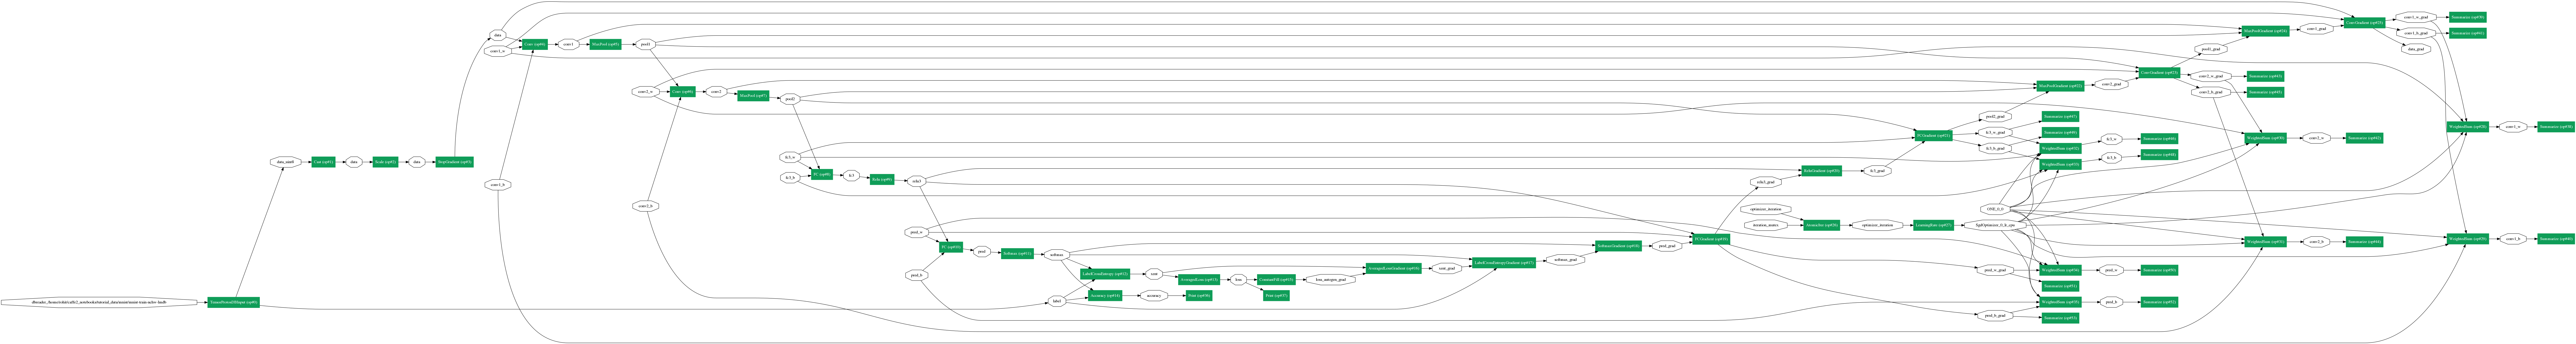

In [11]:
from IPython import display
graph = net_drawer.GetPydotGraph(train_model.net.Proto().op, "mnist", rankdir="LR")
display.Image(graph.create_png(), width=800)

Now, the graph above shows everything that is happening in the training phase: the white nodes are the blobs, and the green rectangular nodes are the operators being run. You may have noticed the massive parallel lines like train tracks: these are dependencies from the blobs generated in the forward pass to their backward operators.

Let's display the graph in a more minimal way by showing only the necessary dependencies and only showing the operators. If you read carefully, you can see that the left half of the graph is the forward pass, the right half of the graph is the backward pass, and on the very right there are a set of parameter update and summarization operators.

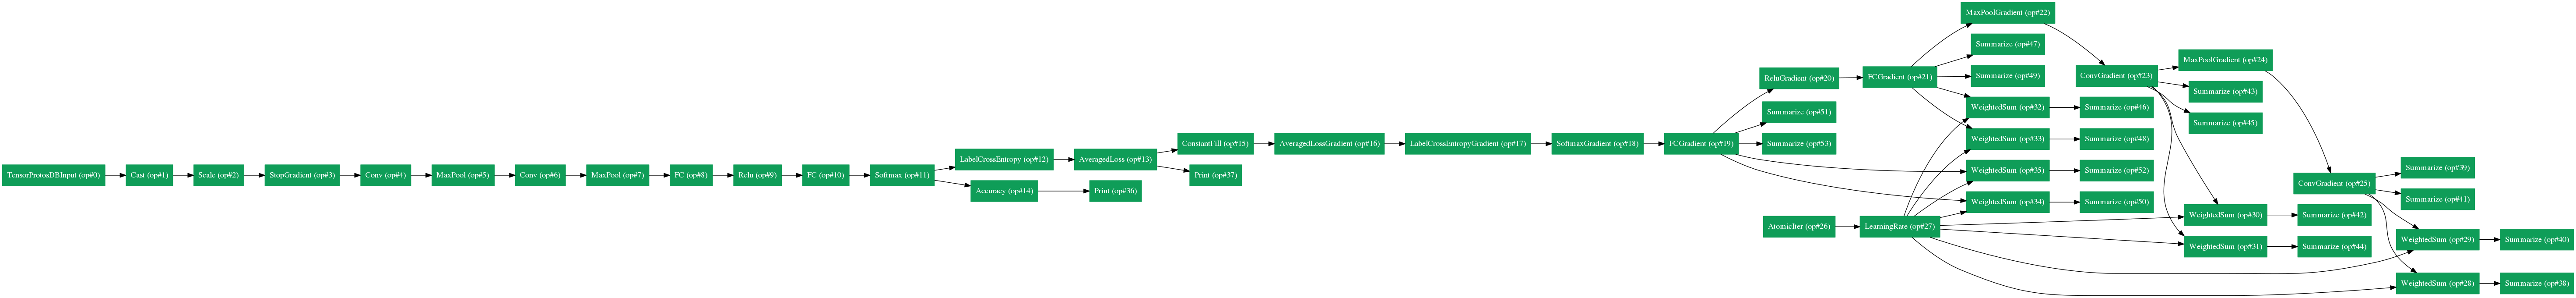

In [12]:
graph = net_drawer.GetPydotGraphMinimal(
    train_model.net.Proto().op, "mnist", rankdir="LR", minimal_dependency=True)
display.Image(graph.create_png(), width=800)

It is important to reiterate here the fact that the ModelHelper class has not executed anything yet. All we have done so far is declare the network, which is basically creating a computation graph specified by the protocol buffers. Here is an example of how we can show a portion of the serialized protocol buffer for the training model's main network and the parameter initialization network.

In [13]:
print("*******train_model.net.Proto()*******\n")
print(str(train_model.net.Proto())[:400] + '\n...')
print("\n*******train_model.param_init_net.Proto()*******\n")
print(str(train_model.param_init_net.Proto())[:400] + '\n...')

*******train_model.net.Proto()*******

name: "mnist_train"
op {
  input: "dbreader_/home/rohit/caffe2_notebooks/tutorial_data/mnist/mnist-train-nchw-lmdb"
  output: "data_uint8"
  output: "label"
  name: ""
  type: "TensorProtosDBInput"
  arg {
    name: "batch_size"
    i: 64
  }
}
op {
  input: "data_uint8"
  output: "data"
  name: ""
  type: "Cast"
  arg {
    name: "to"
    i: 1
  }
}
op {
  input: "data"
  output: "data"
  name: "
...

*******train_model.param_init_net.Proto()*******

name: "mnist_train_init"
op {
  output: "dbreader_/home/rohit/caffe2_notebooks/tutorial_data/mnist/mnist-train-nchw-lmdb"
  name: ""
  type: "CreateDB"
  arg {
    name: "db"
    s: "/home/rohit/caffe2_notebooks/tutorial_data/mnist/mnist-train-nchw-lmdb"
  }
  arg {
    name: "db_type"
    s: "lmdb"
  }
}
op {
  output: "conv1_w"
  name: ""
  type: "XavierFill"
  arg {
    name: "shape"
    ints: 
...


## Run Training

With our model built and our data source specified we can now run the training procedure. Please note that this process may take a while to run. Keep an eye on the asterisk (In [\*]) or other IPython indicators that the code block is still running.

We perform training by just executing our network many times in a row, each time on a fresh batch of inputs. Note, during this process we can fetch values of any blobs in the workspace including accuracy and loss. This allows us to build training plots and periodically monitor the training accuracy and loss. Also, training does not stop once the model has seen all of the data once (1 epoch), rather, it continues until the specified number of iterations is reached.

When using MLP, model accuracy greatly depends on the random initialization of parameters and the number of training iterations. If your model gets stuck at about 50% accuracy, re-run the notebook, which will start from another random seed and new parameter initialization.

In [14]:
# The parameter initialization network only needs to be run once.
# Now all the parameter blobs are initialized in the workspace.
workspace.RunNetOnce(train_model.param_init_net)

# Creating an actual network as a C++ object in memory.
#   We need this as the object is going to be used a lot
#   so we avoid creating an object every single time it is used.
# overwrite=True allows you to run this cell several times and avoid errors
workspace.CreateNet(train_model.net, overwrite=True)

# Set the iterations number and track the accuracy & loss
total_iters = 200
accuracy = np.zeros(total_iters)
loss = np.zeros(total_iters)

# MAIN TRAINING LOOP!
# Now, we will manually run the network for 200 iterations. 
for i in range(total_iters):
    workspace.RunNet(train_model.net)
    accuracy[i] = workspace.blobs['accuracy']
    loss[i] = workspace.blobs['loss']
    # Check the accuracy and loss every so often
    if i % 25 == 0:
        print("Iter: {}, Loss: {}, Accuracy: {}".format(i,loss[i],accuracy[i]))

# After the execution is done, let's plot the values.
pyplot.plot(loss, 'b')
pyplot.plot(accuracy, 'r')
pyplot.title("Summary of Training Run")
pyplot.xlabel("Iteration")
pyplot.legend(('Loss', 'Accuracy'), loc='upper right')

RuntimeError: [enforce fail at db.h:190] db_. Cannot open db: /home/rohit/caffe2_notebooks/tutorial_data/mnist/mnist-train-nchw-lmdb of type lmdb Error from operator: 
output: "dbreader_/home/rohit/caffe2_notebooks/tutorial_data/mnist/mnist-train-nchw-lmdb" name: "" type: "CreateDB" arg { name: "db" s: "/home/rohit/caffe2_notebooks/tutorial_data/mnist/mnist-train-nchw-lmdb" } arg { name: "db_type" s: "lmdb" }

## Visualize Results

Now that our model is trained we can visualize the results of our labors. But first, check out what was printed during the training run above. In the first iteration, the training accuracy for batch 0 was 3.1%, but it quickly converged to mid-nineties by the 100th iteration. The plot also shows this trend. 

This is a good sign!

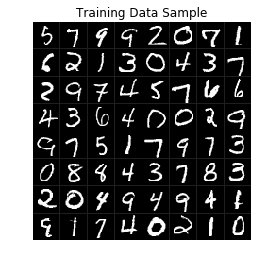

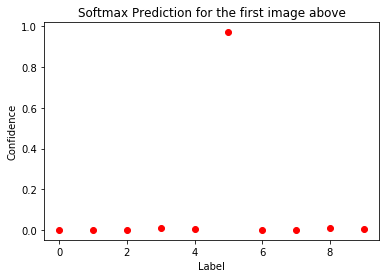

In [15]:
### Let's look at some of the training data
pyplot.figure()
pyplot.title("Training Data Sample")
# Grab the most recent data blob (i.e. batch) from the workspace
data = workspace.FetchBlob('data')
# Use visualize module to show the examples from the last batch that was fed to the model
_ = visualize.NCHW.ShowMultiple(data)

### Let's visualize the softmax result
pyplot.figure()
pyplot.title('Softmax Prediction for the first image above')
pyplot.ylabel('Confidence')
pyplot.xlabel('Label')
# Grab and visualize the softmax blob for the batch we just visualized. Since batch size
#  is 64, the softmax blob contains 64 vectors, one for each image in the batch. To grab
#  the vector for the first image, we can simply index the fetched softmax blob at zero.
softmax = workspace.FetchBlob('softmax')
_ = pyplot.plot(softmax[0], 'ro')

### Visualize Learned Convolutional Filters

Note: This is only applicable if LeNet model was used (*USE_LENET_MODEL = True*)

For convolutional models we can also see how they "think", i.e. which features they come up with. Instead of fetching learned weights, which can make less sense to a human, we fetch results of convolving those weights over the input. Here, we grab the output feature maps of the first convolutional layer, *conv1*, which are the result of convolving the first layer filters with the most recent training data batch. Note that if this code is rerun after the evaluation phase, the last mini-batch will change, since evaluation and training share the same workspace.

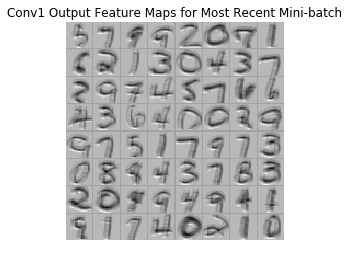

In [16]:
if USE_LENET_MODEL:
    pyplot.figure()
    pyplot.title("Conv1 Output Feature Maps for Most Recent Mini-batch")
    # Grab the output feature maps of conv1. Change this to conv2 in order to look into the second one.
    #  Remember, early convolutional layers tend to learn human-interpretable features but later conv
    #  layers work with highly-abstract representations. For this reason, it may be harder to understand
    #  features of the later conv layers.
    conv = workspace.FetchBlob('conv1')
    
    # We can look into any channel. Think of it as a feature model learned.
    # In this case we look into the 5th channel. Play with other channels to see other features
    conv = conv[:,[5],:,:]

    _ = visualize.NCHW.ShowMultiple(conv)


## Test Model

Remember that we created a test net? Now that we have trained our model, and our workspace contains the trained model parameters, we can run the test pass on the previously unseen test data to check our generalization performance in the form of a test accuracy statistic. Although *test_model* will be using the parameters obtained from *train_model*, *test_model.param_init_net* must still be run to initialize the input data.

We are only going to run 100 iterations because we have 10,000 test images and our batch size for the test_model is 100. Also, we will report an average of batch-wise accuracy, rather than reporting accuracy scores for each individual image.

test_accuracy: 0.950600


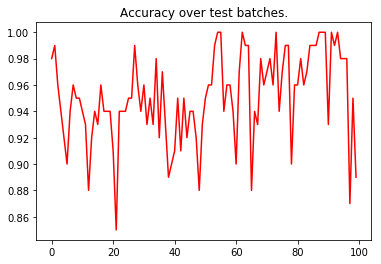

In [17]:
# param_init_net here will only create a data reader
# Other parameters won't be re-created because we selected init_params=False before
workspace.RunNetOnce(test_model.param_init_net)
workspace.CreateNet(test_model.net, overwrite=True)

# Testing Loop 
test_accuracy = np.zeros(100)
for i in range(100):
    # Run a forward pass of the net on the current batch
    workspace.RunNet(test_model.net)
    # Collect the batch accuracy from the workspace
    test_accuracy[i] = workspace.FetchBlob('accuracy')
    
# After the execution is done, let's plot the accuracy values.
pyplot.plot(test_accuracy, 'r')
pyplot.title('Accuracy over test batches.')
print('test_accuracy: %f' % test_accuracy.mean())

## Deploy Model

### Save the Deploy Model

Let's save the deploy model with the trained weights and biases to a file. Hopefully, the importance of this step is evident but this will allow us to bring the model up at another time to run more tests rather, than having to train a model from scratch every time. This step must be done right after training when the trained params are still in the workspace.

In [18]:
# construct the model to be exported
# the inputs/outputs of the model are manually specified.
pe_meta = pe.PredictorExportMeta(
    predict_net=deploy_model.net.Proto(),
    parameters=[str(b) for b in deploy_model.params], 
    inputs=["data"],
    outputs=["softmax"],
)

# save the model to a file. Use minidb as the file format
pe.save_to_db("minidb", os.path.join(root_folder, "mnist_model.minidb"), pe_meta)
print("Deploy model saved to: " + root_folder + "/mnist_model.minidb")

Deploy model saved to: /Users/nathaninkawhich/caffe2_notebooks/tutorial_files/tutorial_mnist/mnist_model.minidb


### Load a Saved Model

Note: For the sake of the tutorial we will do this here, but this section represents how we can load a model that was trained and saved at another time, in a different place.

Let's load the saved deploy model from the previous step and rerun our tests for verification.

The blobs in the workspace after reset: []
The blobs in the workspace after loading the model: [u'!!META_NET_DEF', u'!!PREDICTOR_DBREADER', u'conv1', u'conv1_b', u'conv1_w', u'conv2', u'conv2_b', u'conv2_w', u'data', u'fc3', u'fc3_b', u'fc3_w', u'pool1', u'pool2', u'pred', u'pred_b', u'pred_w', u'relu3', u'softmax']
Shape of softmax:  (100, 10)
Prediction:  8
Confidence:  0.978955


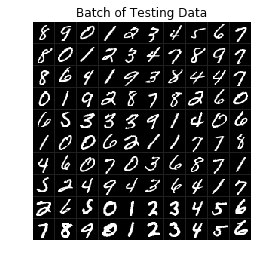

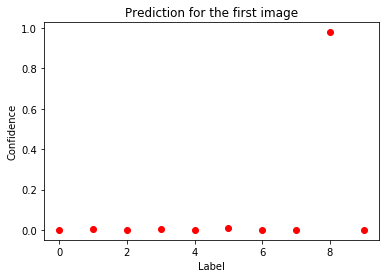

In [19]:
# Grab and display the last data batch used before we scratch the workspace. This purely for our convenience...
blob = workspace.FetchBlob("data")
pyplot.figure()
pyplot.title("Batch of Testing Data")
_ = visualize.NCHW.ShowMultiple(blob)

# reset the workspace, to make sure the model is actually loaded
workspace.ResetWorkspace(root_folder)

# verify that all blobs from training are destroyed. 
print("The blobs in the workspace after reset: {}".format(workspace.Blobs()))

# load the predict net
predict_net = pe.prepare_prediction_net(os.path.join(root_folder, "mnist_model.minidb"), "minidb")

# verify that blobs are loaded back
print("The blobs in the workspace after loading the model: {}".format(workspace.Blobs()))

# feed the previously saved data to the loaded model
workspace.FeedBlob("data", blob)

# predict
workspace.RunNetOnce(predict_net)
softmax = workspace.FetchBlob("softmax")

print("Shape of softmax: ",softmax.shape)

# Quick way to get the top-1 prediction result
# Squeeze out the unnecessary axis. This returns a 1-D array of length 10
# Get the prediction and the confidence by finding the maximum value and index of maximum value in preds array
curr_pred, curr_conf = max(enumerate(softmax[0]), key=operator.itemgetter(1))
print("Prediction: ", curr_pred)
print("Confidence: ", curr_conf)

# the first letter should be predicted correctly
pyplot.figure()
pyplot.title('Prediction for the first image')
pyplot.ylabel('Confidence')
pyplot.xlabel('Label')
_ = pyplot.plot(softmax[0], 'ro')


This concludes the MNIST tutorial. We hope this tutorial highlighted some of Caffe2's features and how easy it is to create a simple MLP or CNN model.